<a href="https://colab.research.google.com/github/zangell44/DS-Unit-2-Sprint-3-Advanced-Regression/blob/master/DS_Unit_2_Sprint_Challenge_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Science Unit 2 Sprint Challenge 3

## Logistic Regression and Beyond

In this sprint challenge you will fit a logistic regression modeling the probability of an adult having an income above 50K. The dataset is available at UCI:

https://archive.ics.uci.edu/ml/datasets/adult

Your goal is to:

1. Load, validate, and clean/prepare the data.
2. Fit a logistic regression model
3. Answer questions based on the results (as well as a few extra questions about the other modules)

Don't let the perfect be the enemy of the good! Manage your time, and make sure to get to all parts. If you get stuck wrestling with the data, simplify it (if necessary, drop features or rows) so you're able to move on. If you have time at the end, you can go back and try to fix/improve.

### Hints

It has a variety of features - some are continuous, but many are categorical. You may find [pandas.get_dummies](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html) (a method to one-hot encode) helpful!

The features have dramatically different ranges. You may find [sklearn.preprocessing.minmax_scale](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.minmax_scale.html#sklearn.preprocessing.minmax_scale) helpful!

## Part 1 - Load, validate, and prepare data

The data is available at: https://archive.ics.uci.edu/ml/datasets/adult

Load it, name the columns, and make sure that you've loaded the data successfully. Note that missing values for categorical variables can essentially be considered another category ("unknown"), and may not need to be dropped.

You should also prepare the data for logistic regression - one-hot encode categorical features as appropriate.

In [0]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# import plotly
# import plotly.plotly as py
# import cufflinks as cf
# import plotly.graph_objs as go
# plotly.tools.set_credentials_file(username='zangell', api_key='bs2CJxqOA2hlrJXKyeM9')

### Load Data

In [149]:

headers = ['age','workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex',
           'capital-gain','capital-loss', 'hours-per-week','native-country', 'over50k']

income_train = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', 
                     header=None, 
                     names=headers,
                    index_col=False)
income_train.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,over50k
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [150]:
income_test = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test',
                         header=None,
                         index_col=False,
                         names=headers)

# theres an annoying header row we'll need to drop
income_test.drop(0, axis=0, inplace=True)

income_test.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,over50k
1,25,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,<=50K.
2,38,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K.
3,28,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,>50K.
4,44,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States,>50K.
5,18,?,103497.0,Some-college,10.0,Never-married,?,Own-child,White,Female,0.0,0.0,30.0,United-States,<=50K.


### Data Cleaning

First, we need to run some sanity checks and do some basic cleaning

- Ensure we have the right number of values
- Ensure missing values are dealth with

Additionally, we need to make some changes to the data, including, but not limited to:

- Encoding target as binary
- Encoding sex as binary
- One hot encoding categorical variables

In [0]:
# ensure we have the correct number of values
# based on UCI, we should have 14 features + 1 target, and 48842 observations
assert income_train.shape[0] + income_test.shape[0] == 48842, print ('Wrong number of observations')
assert income_train.shape[1] == 15 and income_test.shape[1] == 15, print ('Wrong number of features')

In [152]:
# check for null values, UCI says there should be some
# but we don't know how they're encoded, assuming ' ?'
# based on raw data exploration
income_train.replace(' ?', np.nan, inplace=True)
income_train.isnull().sum()


age                  0
workclass         1836
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
over50k              0
dtype: int64

All of our null values occur in large categorical variables. Let's check the value counts for each to see if there's an obvious mode that we could fill with. 

If that is not the case, it is likely best to create a new 'other' category for each variable.

In [153]:
income_train.workclass.value_counts(normalize=True)

 Private             0.738682
 Self-emp-not-inc    0.082701
 Local-gov           0.068120
 State-gov           0.042246
 Self-emp-inc        0.036322
 Federal-gov         0.031245
 Without-pay         0.000456
 Never-worked        0.000228
Name: workclass, dtype: float64

In [154]:
income_train.occupation.value_counts(normalize=True)

 Prof-specialty       0.134774
 Craft-repair         0.133440
 Exec-managerial      0.132365
 Adm-clerical         0.122729
 Sales                0.118823
 Other-service        0.107266
 Machine-op-inspct    0.065174
 Transport-moving     0.051989
 Handlers-cleaners    0.044599
 Farming-fishing      0.032359
 Tech-support         0.030210
 Protective-serv      0.021128
 Priv-house-serv      0.004851
 Armed-Forces         0.000293
Name: occupation, dtype: float64

In [155]:
income_train['native-country'].value_counts(normalize=True)

 United-States                 0.912190
 Mexico                        0.020108
 Philippines                   0.006192
 Germany                       0.004284
 Canada                        0.003784
 Puerto-Rico                   0.003565
 El-Salvador                   0.003315
 India                         0.003127
 Cuba                          0.002971
 England                       0.002814
 Jamaica                       0.002533
 South                         0.002502
 China                         0.002345
 Italy                         0.002283
 Dominican-Republic            0.002189
 Vietnam                       0.002095
 Guatemala                     0.002001
 Japan                         0.001939
 Poland                        0.001876
 Columbia                      0.001845
 Taiwan                        0.001595
 Haiti                         0.001376
 Iran                          0.001345
 Portugal                      0.001157
 Nicaragua                     0.001063


For both 'workclass' and 'native-country', the majority of values come from one class (Private and United-States, respectively). I feel comfortable filling the missing values for these columns with the most frequently occuring value.

For occupation, the distribution is more evenly split. I'm going to choose to encode missing values as 'Other-service', since this category already seems like a catch all for non-standardized professions.

In [0]:
# replace ' ?' with nulls in test data
income_test.replace(' ?', np.nan, inplace=True)

# replace workclass nulls with Private
income_train['workclass'].fillna('Private', inplace=True)
income_test['workclass'].fillna('Private', inplace=True)

# replace native-country nulls with United-States
income_train['native-country'].fillna('United-States', inplace=True)
income_test['native-country'].fillna('United-States', inplace=True)

# replace occupation nulls with Other-service
income_train['occupation'].fillna('Other-service', inplace=True)
income_test['occupation'].fillna('Other-service', inplace=True)

assert income_train.isnull().sum().sum() == 0, print ('Check for reamining null in train data')
assert income_test.isnull().sum().sum() == 0, print ('Check for reamining null in test data')

In [157]:
# encode target variable as binary
income_train['over50k'] = income_train['over50k'] == ' >50K'
income_test['over50k'] = income_test['over50k'] == ' >50K'

# encode sex as binary
income_train['sex'] = income_train['sex'] == ' Male'
income_test['sex'] = income_test['sex'] == ' Male'

income_train.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,over50k
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,True,2174,0,40,United-States,False
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,True,0,0,13,United-States,False
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,True,0,0,40,United-States,False
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,True,0,0,40,United-States,False
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,False,0,0,40,Cuba,False


In [158]:
# one hot encode categorical variables
# first, let's check the data types to make sure numeric variables are really numeric
income_train.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex                 bool
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
over50k             bool
dtype: object

In [0]:
# looks fair enough, let's one hot encode the categorical features
income_train = pd.get_dummies(income_train, prefix_sep="__",
                              columns=['workclass', 'education', 'marital-status',
                                      'occupation', 'relationship', 'race', 'native-country'])
income_test = pd.get_dummies(income_test, prefix_sep="__",
                              columns=['workclass', 'education', 'marital-status',
                                      'occupation', 'relationship', 'race', 'native-country'])

In [160]:
# let's quickly make sure both of these still have the same number of columns
print ('Training features', income_train.shape[1] - 1)
print ('Testing features', income_test.shape[1] - 1)

Training features 107
Testing features 106


In [161]:
# whoops, looks like a category was unique to training and not found in test
# let's try to isolate that
for col in income_train.columns:
  if col not in income_test.columns:
    print (col)

native-country__ Holand-Netherlands


In [0]:
# simple enough, we just didn't have anyone from Holand in the test data
# let's append that column as all zeroes
income_test['native-country__ Holand-Netherlands'] = 0
assert (income_train.shape[1] == income_test.shape[1])

## Part 2 - Fit and present a Logistic Regression

Your data should now be in a state to fit a logistic regression. Use scikit-learn, define your `X` (independent variable) and `y`, and fit a model.

Then, present results - display coefficients in as interpretible a way as you can (hint - scaling the numeric features will help, as it will at least make coefficients more comparable to each other). If you find it helpful for interpretation, you can also generate predictions for cases (like our 5 year old rich kid on the Titanic) or make visualizations - but the goal is your exploration to be able to answer the question, not any particular plot (i.e. don't worry about polishing it).

It is *optional* to use `train_test_split` or validate your model more generally - that is not the core focus for this week. So, it is suggested you focus on fitting a model first, and if you have time at the end you can do further validation.

### Logistic Regression

We're going to use all features except fnlwgt. UCI gives an explanation of this variable, and it appears to relate to the generalization of the findings here to the US population overall based on demographic characteristics.

Since I'm not quite sure what it means, I would prefer to leave it out.

In [0]:
target = 'over50k'
features = income_train.columns.drop([target, 'fnlwgt'])

X_train, y_train = income_train[features], income_train[target]
X_test, y_test = income_test[features], income_test[target]

First, let's fit a regression without standardizing, allowing maximum interpretability. We an analyze afterwards how much standardizing helps.

In [164]:
# first try, to get a baseline for score without standardizing
lr = LogisticRegression(solver='newton-cg')
lr.fit(X_train, y_train)
print ('Training Score (Standardized)', lr.score(X_train, y_train))
print ('Testing Score (Standardized)', lr.score(X_test, y_test))

Training Score (Standardized) 0.852369398974233
Testing Score (Standardized) 0.806707204717155


Next, let's fit a regression scaling the features beforehand. This hinders interpretability a bit, but convergence should occur quicker.

In [165]:
std_scale = StandardScaler()
X_train_std = std_scale.fit_transform(X_train)
X_test_std = std_scale.transform(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:625: DataConversionWarning:

Data with input dtype bool, uint8, int64 were all converted to float64 by StandardScaler.

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:462: DataConversionWarning:

Data with input dtype bool, uint8, int64 were all converted to float64 by StandardScaler.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DataConversionWarning:

Data with input dtype bool, uint8, int64, float64, object were all converted to float64 by StandardScaler.



In [166]:
# first try, to get a baseline for score using standardized features
lr_std = LogisticRegression(solver='newton-cg')
lr_std.fit(X_train_std, y_train)
print ('Training Score (Standardized)', lr.score(X_train_std, y_train))
print ('Testing Score (Standardized)', lr.score(X_test_std, y_test))

Training Score (Standardized) 0.7663769540247536
Testing Score (Standardized) 0.9672624531662675


Not bad, let's see what happens if we adjust the regularization strength. 

In [0]:
c_list = np.arange(0, 10, 0.5)
scores = []

for c in c_list:
  lr_temp = LogisticRegression(C=10**c, solver='newton-cg')
  lr_temp.fit(X_train_std, y_train)
  scores.append(lr_temp.score(X_test_std, y_test))

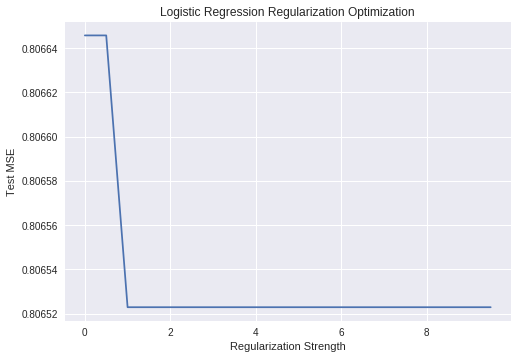

In [168]:
# plottig regularizations strength effects
fig, ax = plt.subplots()
ax.plot(c_list, scores)
ax.set_xlabel('Regularization Strength')
ax.set_ylabel('Test MSE')
ax.set_title('Logistic Regression Regularization Optimization')
plt.show()

The regularization parameter doesn't seem to help us much, overfitting does not seem to be an issue.

Further, in part because of the above statement, standardizing parameters does not help us much. Let's report the coefficients of the unstandardized features, allowing easier interpretation.

In [169]:
print ('-' * 80)
print('{:<50s}{:>15s}{:>15s}'.format('Feature','Coefficient','Odds Ratio'))
print ('-' * 80)

for feat, coef in (zip(income_train[features].columns, lr.coef_[0])):
    print('{:<50s}{:>15f}{:>15f}'.format(feat,round(coef,2),round(np.exp(coef),2)))


--------------------------------------------------------------------------------
Feature                                               Coefficient     Odds Ratio
--------------------------------------------------------------------------------
age                                                      0.030000       1.030000
education-num                                            0.290000       1.340000
sex                                                      0.860000       2.350000
capital-gain                                             0.000000       1.000000
capital-loss                                             0.000000       1.000000
hours-per-week                                           0.030000       1.030000
workclass__ Federal-gov                                  0.730000       2.080000
workclass__ Local-gov                                    0.060000       1.060000
workclass__ Never-worked                                -0.140000       0.870000
workclass__ Private         

## Part 3 - Analysis, Interpretation, and Questions

### Based on your above model, answer the following questions

1. What are 3 features positively correlated with income above 50k?
2. What are 3 features negatively correlated with income above 50k?
3. Overall, how well does the model explain the data and what insights do you derive from it?

*These answers count* - that is, make sure to spend some time on them, connecting to your analysis above. There is no single right answer, but as long as you support your reasoning with evidence you are on the right track.

Note - scikit-learn logistic regression does *not* automatically perform a hypothesis test on coefficients. That is OK - if you scale the data they are more comparable in weight.

### Match the following situation descriptions with the model most appropriate to addressing them

In addition to logistic regression, a number of other approaches were covered this week. Pair them with the situations they are most appropriate for, and briefly explain why.

Situations:
1. You are given data on academic performance of primary school students, and asked to fit a model to help predict "at-risk" students who are likely to receive the bottom tier of grades.
2. You are studying tech companies and their patterns in releasing new products, and would like to be able to model and predict when a new product is likely to be launched.
3. You are working on modeling expected plant size and yield with a laboratory that is able to capture fantastically detailed physical data about plants, but only of a few dozen plants at a time.

Approaches:

1. Ridge Regression
2. Quantile Regression
3. Survival Analysis

### Logistic Regression Questions

***1. What are 3 features positively correlated with income above 50k?***

The table below details all regression features that are positively correlated with income above 50k. The magnitude of the relationship varies widely.

From the table below, we can examine a few that standout.

**Sex**

Males are about 2.35 times as likely to earn more than 50k.

**Marriage**

Being married to a civilian or armed forces member (Married-civ-spouse or Married-AF-spouse), or being in a relationship with a wife, are strong indicators of making over 50k. Precense of these attributes increases the likelihood of income over 50k by 3.45-4.93 times.

**Working for the Federal Govt**

A federal government worker is 2.08 times as likely to make over 50k as those working in other sectors.

In [170]:
# print out features positively correlated with income
print ('-' * 80)
print('{:<50s}{:>15s}{:>15s}'.format('Feature - Positively Correlated','Coefficient','Odds Ratio'))
print ('-' * 80)

for feat, coef in (zip(income_train[features].columns, lr.coef_[0])):
  if coef > 0.0:
    print('{:<50s}{:>15f}{:>15f}'.format(feat,round(coef,2),round(np.exp(coef),2)))


--------------------------------------------------------------------------------
Feature - Positively Correlated                       Coefficient     Odds Ratio
--------------------------------------------------------------------------------
age                                                      0.030000       1.030000
education-num                                            0.290000       1.340000
sex                                                      0.860000       2.350000
capital-gain                                             0.000000       1.000000
capital-loss                                             0.000000       1.000000
hours-per-week                                           0.030000       1.030000
workclass__ Federal-gov                                  0.730000       2.080000
workclass__ Local-gov                                    0.060000       1.060000
workclass__ Private                                      0.240000       1.280000
workclass__ Self-emp-inc    

***2. What are 3 features negatively correlated with income above 50k?***

The table below details all regression features that are positively correlated with income above 50k. The magnitude of the relationship varies widely.

From the table below, we can examine a few that standout.

**Low Education Levels**

Although more chances of making over 50k do not increase monotonically with education levels, low education levels are associated with lower income generally, particularly in the extreme cases.

Someone with only a preschool education has 0.31 times the chance of making over 50k, all else equal.

**Immigration From Poorer Countries**

People who immigrated from especially poor countries like Columbia, the Dominican Republic, and Vietnam tend not to have income exceeding 50k.

**Occupation**

There seems to be a large disparity in pay between occupations. People who work in private house service (likely performing manual labor tasks), are 0.2 times as likely to have income exceeding 50k.

In [171]:
# print out features negatively correlated with income
print ('-' * 80)
print('{:<50s}{:>15s}{:>15s}'.format('Feature - Negatively Correlated','Coefficient','Odds Ratio'))
print ('-' * 80)

for feat, coef in (zip(income_train[features].columns, lr.coef_[0])):
  if coef < 0.0:
    print('{:<50s}{:>15f}{:>15f}'.format(feat,round(coef,2),round(np.exp(coef),2)))


--------------------------------------------------------------------------------
Feature - Negatively Correlated                       Coefficient     Odds Ratio
--------------------------------------------------------------------------------
workclass__ Never-worked                                -0.140000       0.870000
workclass__ Self-emp-not-inc                            -0.250000       0.780000
workclass__ State-gov                                   -0.070000       0.930000
workclass__ Without-pay                                 -0.920000       0.400000
workclass__Private                                      -0.060000       0.940000
education__ 11th                                        -0.150000       0.860000
education__ 12th                                        -0.050000       0.960000
education__ Assoc-acdm                                  -0.370000       0.690000
education__ Assoc-voc                                   -0.070000       0.930000
education__ Bachelors       

3. Overall, how well does the model explain the data and what insights do you derive from it?

The classification accuracy on our test data was around 80%, a fairly high accuracy given the situation.

That said, the degree of accuracy acheived by a simple logistic regression is concerning. Our features mainly consist of structural factors (education, race, sex, industry). 

In an ideal world, almost none of these structural factors should predict income. We would prefer that *sex*, for example,  has no predictive power, and that men and women have equal earning power.

The question is incredibly complex, and socioeconomic relationships are constantly changing. It would be interesting to see how model accuracy changes as applied to new years of census data.

### Model Matching

1. You are given data on academic performance of primary school students, and asked to fit a model to help predict "at-risk" students who are likely to receive the bottom tier of grades.

**Quantile Regression**

Quantile regression creates a line of best fit through a given output quantile (0-100%), instead of through the mean output values.

In this case, we would establish a quantile that we would consider the bottom 'tier' of grades. Let's say the bottom 10%.

From there, we would use a quantile regression model to predict a line of best fit. Meaning, conditional on X, only 10% of true values would lie below our prediction value.

2. You are studying tech companies and their patterns in releasing new products, and would like to be able to model and predict when a new product is likely to be launched.

**Survival Analysis**

In this case, we can think of the release of a new product as a 'death' event in survival analysis. 

If the description is referencing the replacement of an existing product, we would represent the existing product as the 'birth' event. If the description is representing a general innovation of a new product, we would represent the release of the last innovative product as the 'birth' event.

Either way, survival analysis allows us to fit a model when many of the data points are censored. For example, Google will almost certainly release a new version of GMail. However, since we haven't been able to observe that yet, all we know is "it has been X months since the last version of GMail was released". 

Survival analysis allows us to correct for this censorship in our data.

3. You are working on modeling expected plant size and yield with a laboratory that is able to capture fantastically detailed physical data about plants, but only of a few dozen plants at a time.

**Ridge Regression**

In this case, we have *a lot* of features captured from the physical data, but very few observations. Normal regression techniques are prone to overfitting in these circumstances.

Ridge regression places a cost on the size of regression coefficients. This bias introduced by ridge regression mitigates overfitting, and will allow our model to generalize better from the few dozen observations in our data.